In [1]:
!git status

On branch master
Your branch is up-to-date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.ipynb_checkpoints/Seq2Seq-Beijing-Infer-checkpoint.ipynb
	Seq2Seq-Beijing-Infer.ipynb

nothing added to commit but untracked files present (use "git add" to track)


In [2]:
!git pull origin master

From https://github.com/Adrian-Gordon/seq2seq-sagemaker
 * branch            master     -> FETCH_HEAD
Already up-to-date.


In [1]:
#Load Configuration
from sagemaker import get_execution_role

import boto3

import json

role = get_execution_role()

bucket='culturehub'

#get the data
data_key = 'seqtoseq/PRSA_data_2010.1.1-2014.12.31.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

#get the configuration

configuration_key ='seqtoseq/config_beijing.json'
configuration_location = 's3://{}/{}'.format(bucket, configuration_key)

configuration_string = boto3.resource('s3').Object(bucket, configuration_key).get()['Body'].read().decode('utf-8')

print("Configuration:")
print(configuration_string)

config = json.loads(configuration_string)


Configuration:
{
"data_modulename":"generate_beijing_data",
"datafilename": "./data/PRSA_data_2010.1.1-2014.12.31.csv",
"savefilename":"beijing-seq2seq0",
"input_sequence_length": 30,
"output_sequence_length": 5,
"batch_size" :16,
"input_dim" : 11,
"output_dim":1,
"num_stacked_layers" :2,
"hidden_dim" :64,
"learning_rate" :0.01,
"l2_regularization_lambda":0.03,
"gradient_clipping": 2.5,
"epochs": 100
}


In [2]:
#get the data

from generatedata import *

bucket='culturehub'
data_key = 'seqtoseq/PRSA_data_2010.1.1-2014.12.31.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
gd=GenerateData(data_location)
print(gd.data.head())



s3://culturehub/seqtoseq/PRSA_data_2010.1.1-2014.12.31.csv
   No  year  month  day  hour     pm2.5      DEWP      TEMP      PRES  \
0   1  2010      1    1     0 -1.018534 -1.580878 -1.922250  0.443328   
1   2  2010      1    1     1 -1.018534 -1.580878 -2.004228  0.345943   
2   3  2010      1    1     2 -1.018534 -1.580878 -1.922250  0.248559   
3   4  2010      1    1     3 -1.018534 -1.580878 -2.168183  0.248559   
4   5  2010      1    1     4 -1.018534 -1.511594 -2.004228  0.151174   

        Iws        Is        Ir  cbwd_NE  cbwd_NW  cbwd_SE  cbwd_cv  
0 -0.441894 -0.069353 -0.137667        0        1        0        0  
1 -0.379306 -0.069353 -0.137667        0        1        0        0  
2 -0.343514 -0.069353 -0.137667        0        1        0        0  
3 -0.280926 -0.069353 -0.137667        0        1        0        0  
4 -0.218339 -0.069353 -0.137667        0        1        0        0  


test mse is:  0.4420802178791832


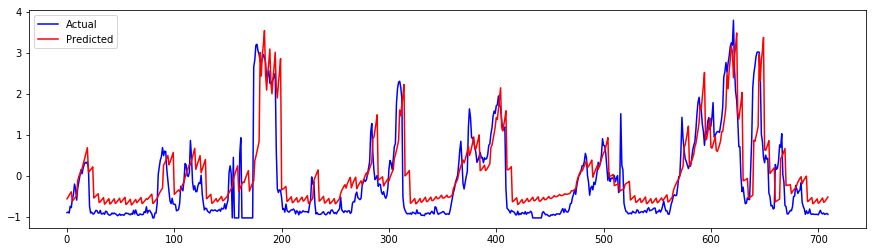

In [3]:
#Inference
%matplotlib inline

import tensorflow as tf

from seq2seqmodel import *

import numpy as np

import os

from matplotlib import pyplot as plt

def main():
    
    seq2seqInference  = Seq2Seq(config)
    init = tf.global_variables_initializer()
    
    sequence_length = config["input_sequence_length"] + config["output_sequence_length"]
    n_iterations = int((len(GenerateData.X_test) /config["output_sequence_length"]) -6)
    with tf.Session() as sess:
        sess.run(init)
        #restore the network state
        saver = tf.train.Saver
        saver().restore(sess, os.path.join('./',config["savefilename"]))
        
        offset = 0
        actual_output = []
        test_output = []
        
        for iteration in range(n_iterations):
            test_sequence_input, test_sequence_output = gd.getTestSample(config["input_sequence_length"], config["output_sequence_length"], offset)
            test_sequence_input = test_sequence_input[0]
            feed_dict = {seq2seqInference.encoder_inputs[t]: test_sequence_input[t].reshape(1,config["input_dim"]) for t in range(config["input_sequence_length"])}
            feed_dict.update({seq2seqInference.decoder_target_inputs[t]: np.zeros([1,config["output_dim"]]) for t in range(config["output_sequence_length"])})
    
            test_in = test_sequence_input.transpose()
            test_out = np.array(sess.run(seq2seqInference.encoder_decoder_inference, feed_dict)).transpose()
            test_output.append(test_out)
            
            actual_output.append(test_sequence_output.reshape(-1))
            
            offset += config["output_sequence_length"]
            
        actual_output = np.array(actual_output).reshape(-1)
        test_output = np.array(test_output).reshape(-1)
        
        print("test mse is: ", np.mean((actual_output - test_output)**2))
        
        plt.figure(figsize=(15,4))
        l1, = plt.plot(actual_output, 'b-', label = 'Actual')
        l2, = plt.plot(test_output, 'r-', label = 'Predicted')
        
        plt.legend(handles=[l1,l2], loc = 'upper left')

        plt.show()
        
main()
        
        
        
            
            
    

In [4]:
!git add .

On branch master
Your branch is up-to-date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   __pycache__/generatedata.cpython-36.pyc
	modified:   __pycache__/seq2seqmodel.cpython-36.pyc

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.ipynb_checkpoints/Seq2Seq-Beijing-Infer-checkpoint.ipynb
	Seq2Seq-Beijing-Infer.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
